# ДЗ 2:

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)


В каждом случае фиксировать, на сколько сокращается дисперсия, проверять равны ли средние в группах в ковариате и совпадают ли средние в метрике до и после применения cuped
(+ 5 балла за обьяснения и выводы)


3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)


4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


(+ 5 балла за обьяснения и выводы)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections
from joblib import Parallel, delayed
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')

In [3]:
def groups_splitter(df, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[['user_id', 'group']].drop_duplicates()

In [4]:
df_hw = pd.read_csv('df_hw.csv')
shop_metrics_new = pd.read_csv('shop_df_metrics_dec.csv').drop(columns='Unnamed: 0')
shop_metrics_old = pd.read_csv('shop_df_metrics_sept.csv').drop(columns='Unnamed: 0')
shop_users_info = pd.read_csv('shop_df_users.csv').drop(columns='Unnamed: 0')

In [5]:
shop_metrics_new

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0


Метрики:
   - is_viewed - айтем товара просмотрен
   - products_viewed_cnt - количество уникальных просмотренных айтемов
   - price_sum - суммарная цена товаров
   - is_cart_added - товар добавлен в корзину
   - is_purchased - товар куплен
   - cart_added_cnt - количество товаров, добавленных в корзину
   - purchased_cnt - количество купленных товаров

<Axes: xlabel='cart_added_cnt', ylabel='Count'>

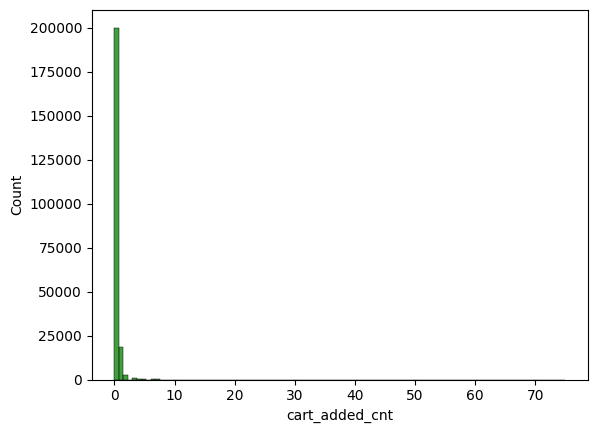

In [6]:
sns.histplot(data=shop_metrics_new, x='cart_added_cnt', bins=100, color='green')

In [7]:
shop_metrics_new.groupby('group')['cart_added_cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,111321.0,0.135042,0.616917,0.0,0.0,0.0,0.0,61.0
B,111200.0,0.138552,0.651705,0.0,0.0,0.0,0.0,75.0


In [8]:
np.percentile(shop_metrics_new['cart_added_cnt'], 99.9)

6.0

In [9]:
shop_metrics_new[shop_metrics_new['cart_added_cnt'] > 50].count()

user_id                4
group                  4
is_viewed              4
products_viewed_cnt    4
price_sum              4
is_cart_added          4
is_purchased           4
cart_added_cnt         4
purchased_cnt          4
dtype: int64

In [10]:
shop = shop_metrics_new.drop(columns=['group'])

In [11]:
shop['cart_added_cnt'].std()

0.6345408834915941

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


0.011261063159214902
 power: 14.000000000000002% , correctness: 90.0%


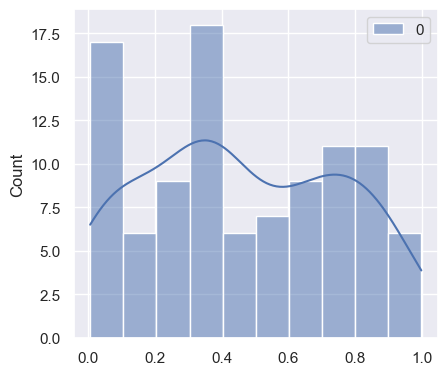

In [12]:
# мощность и корректность t-test для исходной метрики

correctness = []
power = []
# 

def compute_iterration(i, shop):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']
    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * 1.01
    # vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = stats.ttest_ind(vec_a, vec_b)[1], stats.ttest_ind(vec_a, vec_b_effect)[1]
    correctness.append(p_cor)
    power.append(p_power)
    
    return correctness, power, vec_b_effect, vec_a
    
results = Parallel(n_jobs=-1)(delayed(compute_iterration)(i, shop) for i in tqdm(range(100)))

correctness, power, vec_b_effect, vec_a = zip(*results)

vec_b_effect = np.concatenate(vec_b_effect)
vec_a = np.concatenate(vec_a)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='purple', kde=True)

power = np.array(power)
print((vec_b_effect.mean() - vec_a.mean())/vec_a.mean())
print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

1. Применить ранговую трансформацию (потом t-test) и сравнить с результатами по Манну-Уитни на:
- метрике cart_added_cnt (5 баллов)

In [13]:
def rank_transformation(df_a, df_b, metric):
    df = pd.concat([df_a, df_b], axis = 0)
    df['rank'] = df[metric].rank()

    return df

In [14]:
ranked = rank_transformation(shop_metrics_new[shop_metrics_new.group == 'A'],
                             shop_metrics_new[shop_metrics_new.group == 'B'], 'cart_added_cnt')

In [15]:
ranked

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,100038.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,100038.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,100038.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,100038.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,100038.5
...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,100038.5
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,100038.5
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,100038.5
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,100038.5


In [16]:
ranked[ranked['cart_added_cnt'] > 0]

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,rank
13,1515915625353706476,A,1,12,522.75,0.0,0.0,2,0,219885.0
33,1515915625355805313,A,1,4,1336.40,0.0,0.0,1,0,209349.0
36,1515915625356129712,A,1,4,144.42,0.0,0.0,1,0,209349.0
108,1515915625367976920,A,1,4,144.83,0.0,0.0,1,1,209349.0
113,1515915625368720412,A,1,2,425.56,0.0,0.0,1,0,209349.0
...,...,...,...,...,...,...,...,...,...,...
222375,1515915625611002957,B,1,1,490.54,0.0,0.0,1,0,209349.0
222403,1515915625611007170,B,1,1,839.75,0.0,0.0,1,0,209349.0
222424,1515915625611010717,B,1,3,1493.89,0.0,0.0,2,0,219885.0
222440,1515915625611013140,B,1,2,642.29,0.0,0.0,2,0,219885.0


In [17]:
print(ranked[ranked.group == 'A']['rank'].mean(),
      ranked[ranked.group == 'B']['rank'].mean(),
      ((ranked[ranked.group == 'B']['rank'].mean() - ranked[ranked.group == 'A']['rank'].mean()) /
       ranked[ranked.group == 'A']['rank'].mean()*100))

111170.45633348604 111351.6421897482 0.16298022175842064


In [18]:
st_ttest = stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])

print("T-тест:")
print("Статистика t: {:.2f}".format(st_ttest.statistic))
print("P-значение: {:.4f}".format(st_ttest.pvalue))
print("Степени свободы: {:.1f}".format(st_ttest.df))

T-тест:
Статистика t: -1.27
P-значение: 0.2025
Степени свободы: 222519.0


Различия между группами минимальны => t-test не нашел разницу

100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


 power: 99.9% , correctness: 95.1%


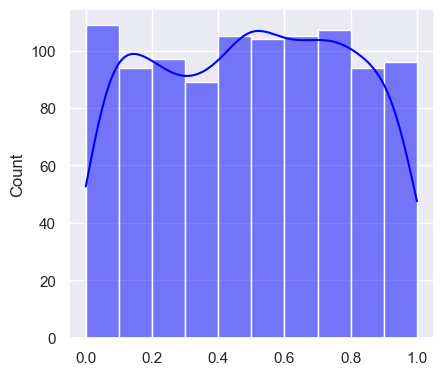

In [19]:
correctness = []
power = []

def compute_check_power_cor(i, shop, effect=1.01, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    ranked_df = rank_transformation(new_df[new_df.group == 'A'], new_df[new_df.group == 'B'], 'cart_added_cnt')

    vec_a = ranked_df[(ranked_df['group'] == 'A')]['rank']
    vec_b = ranked_df[(ranked_df['group'] == 'B')]['rank']

    vec_b_effect = new_df[new_df['group'] == 'B']['cart_added_cnt'] * effect
    new_df_b = new_df[new_df.group == 'B'].drop(columns=['cart_added_cnt'])
    new_df_b['cart_added_cnt'] = list(vec_b_effect)

    ranked_df_effect = rank_transformation(new_df[new_df.group == 'A'], new_df_b, 'cart_added_cnt')
    vec_a_power = ranked_df_effect[(ranked_df_effect['group'] == 'A')]['rank']
    vec_b_power = ranked_df_effect[(ranked_df_effect['group'] == 'B')]['rank']


    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a_power, vec_b_power).pvalue
    return p_cor, p_power
    
    
results = Parallel(n_jobs=-1)(delayed(compute_check_power_cor)(i, shop) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

После применения ранговой трансформации мощность стала 100%.

In [20]:
man_test = stats.mannwhitneyu(shop_metrics_new[shop_metrics_new.group == 'A']['cart_added_cnt'],
                   shop_metrics_new[shop_metrics_new.group == 'B']['cart_added_cnt'])


print("Манна-Уитни::")
print("Статистика t: {:.2f}".format(man_test.statistic))
print("P-значение: {:.4f}".format(man_test.pvalue))

Манна-Уитни::
Статистика t: 6179368188.50
P-значение: 0.2025


100%|██████████| 1000/1000 [03:24<00:00,  4.89it/s]


 power: 100.0% , correctness: 95.7%


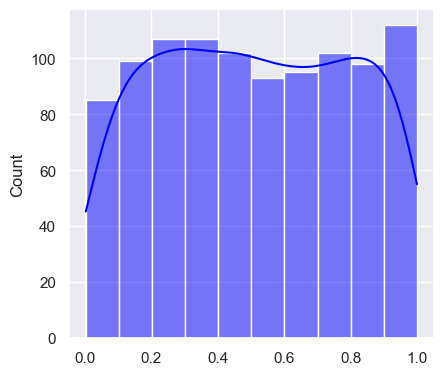

In [21]:
results = Parallel(n_jobs=-1)(delayed(compute_check_power_cor)(i, shop, 1.01, criterion = stats.mannwhitneyu) for i in tqdm(range(1000)))

correctness = np.array([p[0] for p in results])
power = np.array([p[1] for p in results])

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='blue', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

P_value в обоих случаях одинаковые и говорят нам, что различия между группами минимальны.

2. Реализовать cuped-трансформацию и сравнить мощность t-критерия на:
- обычной метрике cart_added_cnt (5 баллов)
- логарфимированной метрике cart_added_cnt (5 баллов)
- метрике cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

In [22]:
def print_group_mean_var(df, metric):

    group_a_mean = round(df[df.group == "A"][metric].mean(), 4)
    group_b_mean = round(df[df.group == "B"][metric].mean(), 4)
    group_a_var = round(df[df.group == "A"][metric].var(), 4)
    group_b_var = round(df[df.group == "B"][metric].var(), 4)
    group_a_cuped_mean = round(df[df.group == "A"][f"{metric}_cuped"].mean(), 4)
    group_b_cuped_mean = round(df[df.group == "B"][f"{metric}_cuped"].mean(), 4)
    group_a_cuped_var = round(df[df.group == "A"][f"{metric}_cuped"].var(), 4)
    group_b_cuped_var = round(df[df.group == "B"][f"{metric}_cuped"].var(), 4)


    print('Cредние:')
    print()
    print(f"c CUPED в группе A: {group_a_cuped_mean}, c CUPED в группе B: {group_b_cuped_mean}")
    print(f"без CUPED в группе A: {group_a_mean}, без CUPED в группе B: {group_b_mean}")
    print()
    print('\nСравним дисперсии:')
    print()
    print(f"с CUPED в группе A: {group_a_cuped_var}, с CUPED в группе B: {group_b_cuped_var}")
    print(f"без CUPED в группе A: {group_a_var}, без CUPED в группе B: {group_b_var}")
    print()
    print(f"Разница дисперсии метрик с CUPED и без в группе A: {group_a_var - group_a_cuped_var}")
    print(f"Разница дисперсии метрик с CUPED и без в группе B: {group_b_var - group_b_cuped_var}")

In [23]:
def cuped_transform(df, metrics):

    new_columns = [str(m+'_cuped') for m in metrics]
    df[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)

    df_mini = df.fillna(0)
    for m in metrics:
        covariate_column = str(m+'_covariate')
        cuped_column = str(m+'_cuped')
        mean_covariate = df_mini[covariate_column].mean()

        theta = (df_mini[m].cov(df_mini[covariate_column]))/(df_mini.loc[:,covariate_column].var())
        df_mini[cuped_column] = df_mini[m] - (df_mini[covariate_column] - mean_covariate) * theta

    df.update(df_mini)

    return df.drop_duplicates()


In [24]:
shop_metrics_old.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt
0,1515915625353226922,B,1,1,76.48,0.0,0.0,0,0
1,1515915625353230067,A,1,1,28.98,0.0,0.0,0,0
2,1515915625353230683,A,1,10,592.21,0.0,0.0,0,0
3,1515915625353230922,A,1,1,274.40,0.0,0.0,0,0
4,1515915625353234047,A,1,14,1857.94,0.0,0.0,0,0


In [25]:
shop_metrics_all = pd.merge(shop_metrics_new, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')

In [26]:
shop_metrics_all = shop_metrics_all.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

In [27]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

C:\Users\alshe\AppData\Local\Temp\ipykernel_31760\3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [28]:
shop_metrics_all_cuped

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,0.132761
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,0.132761
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,0.132761
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,0.132761
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,0.132761
...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0,0.132761
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0,0.132761
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0,0.132761
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0,0.132761


In [29]:
print_group_mean_var(shop_metrics_all_cuped, 'cart_added_cnt')

Cредние:

c CUPED в группе A: 0.1364, c CUPED в группе B: 0.1372
без CUPED в группе A: 0.135, без CUPED в группе B: 0.1386


Сравним дисперсии:

с CUPED в группе A: 0.0182, с CUPED в группе B: 0.0215
без CUPED в группе A: 0.3806, без CUPED в группе B: 0.4247

Разница дисперсии метрик с CUPED и без в группе A: 0.3624
Разница дисперсии метрик с CUPED и без в группе B: 0.4032


Средние не поменялись, дисперсия уменшилась на порядок

In [30]:
tt_cuped = stats.ttest_ind(shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A']['cart_added_cnt_cuped'],
                shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B']['cart_added_cnt_cuped'])

print("T-тест:")
print("Статистика t: {:.2f}".format(tt_cuped.statistic))
print("P-значение: {:.4f}".format(tt_cuped.pvalue))
print("Степени свободы: {:.1f}".format(tt_cuped.df))

T-тест:
Статистика t: -1.39
P-значение: 0.1659
Степени свободы: 222519.0


Т-тест не обнаружил изменений

In [31]:
def cor_pow_cuped(i, shop, effect=1.01, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_cuped']

    vec_b_effect = vec_b * effect


    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a, vec_b_effect).pvalue
    return p_cor, p_power

Посмотрим мощность на 1%

100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]


 power: 60.6% , correctness: 94.3%


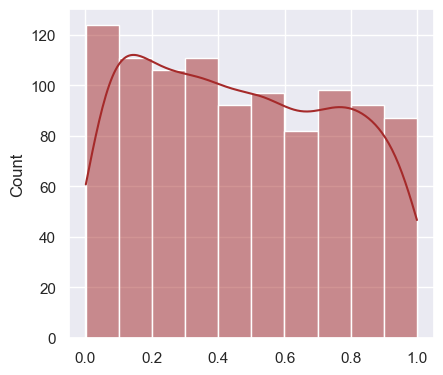

In [32]:
correctness = []
power = []

results = Parallel(n_jobs=-1)(delayed(cor_pow_cuped)(i, shop, 1.01, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Мощность увеличилась с 8% до 62%

- Логарфимированная метрика cart_added_cnt:

In [33]:
shop_metrics_all['cart_added_cnt_ln'] = np.log(shop_metrics_all['cart_added_cnt'] + 0.1**200)
shop_metrics_all['cart_added_cnt_ln_covariate'] = np.log(shop_metrics_all['cart_added_cnt_covariate'] + 0.1**200)

shop_metrics_all_ln_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt_ln'])

C:\Users\alshe\AppData\Local\Temp\ipykernel_31760\3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-414.04947451 -414.04947451 -414.04947451 ... -414.04947451 -414.04947451
 -414.04947451]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [34]:
shop_metrics_all_ln_cuped

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_ln,cart_added_cnt_ln_covariate,cart_added_cnt_ln_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222516,1515915625611023671,B,1,1,32.22,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
222517,1515915625611023730,B,1,1,219.94,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
222518,1515915625611024014,B,1,1,80.03,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
222519,1515915625611024020,B,1,1,64.92,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475


In [35]:
print_group_mean_var(shop_metrics_all_ln_cuped, 'cart_added_cnt_ln')

Cредние:

c CUPED в группе A: -414.121, c CUPED в группе B: -413.9776
без CUPED в группе A: -414.4121, без CUPED в группе B: -413.6862


Сравним дисперсии:

с CUPED в группе A: 455.3953, с CUPED в группе B: 397.2743
без CUPED в группе A: 19114.1579, без CUPED в группе B: 19381.3591

Разница дисперсии метрик с CUPED и без в группе A: 18658.7626
Разница дисперсии метрик с CUPED и без в группе B: 18984.0848


Средние не изменились, дисперсии уменьшились на порядок

In [36]:
ttest_ln_cuped = stats.ttest_ind(
    shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'A']['cart_added_cnt_ln_cuped'],
    shop_metrics_all_ln_cuped[shop_metrics_all_ln_cuped.group == 'B']['cart_added_cnt_ln_cuped']
)

print("T-тест:")
print("Статистика t: {:.2f}".format(ttest_ln_cuped.statistic))
print("P-значение: {:.4f}".format(ttest_ln_cuped.pvalue))
print("Степени свободы: {:.1f}".format(ttest_ln_cuped.df))

T-тест:
Статистика t: -1.64
P-значение: 0.1012
Степени свободы: 222519.0


In [37]:
shop_metrics_all_ln_cuped.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_ln,cart_added_cnt_ln_covariate,cart_added_cnt_ln_cuped
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
3,1515915625353294441,B,1,28,4283.04,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475
4,1515915625353386199,B,1,1,20.98,0.0,0.0,0,0,0,-460.517019,-460.517019,-414.049475


In [38]:
def cor_pow_ln_cuped(i, shop, effect=1.01, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    all_df['cart_added_cnt_ln'] = np.log(all_df['cart_added_cnt'] + 1)
    all_df['cart_added_cnt_ln_covariate'] = np.log(all_df['cart_added_cnt_covariate'] + 1)

    cuped_df = cuped_transform(all_df, ['cart_added_cnt_ln'])

    vec_a = cuped_df[(cuped_df['group'] == 'A')]['cart_added_cnt_ln_cuped']
    vec_b = cuped_df[(cuped_df['group'] == 'B')]['cart_added_cnt_ln_cuped']

    vec_b_effect = vec_b + np.log(effect)


    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a, vec_b_effect).pvalue
    return p_cor, p_power

Мощность на 1%

100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


 power: 100.0% , correctness: 94.8%


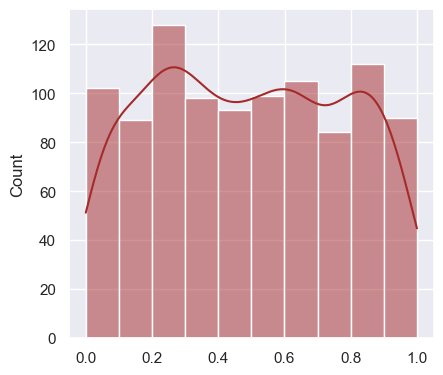

In [39]:
correctness = []
power = []

results = Parallel(n_jobs=-1)(delayed(cor_pow_ln_cuped)(i, shop, 1.01, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

- cart_added_cnt (а после подвергнуть ранговому преобразованию) (5 баллов)

In [40]:
shop_metrics_all_cuped = cuped_transform(shop_metrics_all.copy(), ['cart_added_cnt'])

ranked = rank_transformation(
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'A'],
    shop_metrics_all_cuped[shop_metrics_all_cuped.group == 'B'], 'cart_added_cnt_cuped'
)

C:\Users\alshe\AppData\Local\Temp\ipykernel_31760\3236988277.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.1327605 0.1327605 0.1327605 ... 0.1327605 0.1327605 0.1327605]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.update(df_mini)


In [41]:
ranked.head()

,user_id,group,is_viewed,products_viewed_cnt,price_sum,is_cart_added,is_purchased,cart_added_cnt,purchased_cnt,cart_added_cnt_covariate,cart_added_cnt_ln,cart_added_cnt_ln_covariate,cart_added_cnt_cuped,rank
0,1515915625353230683,A,1,1,339.79,0.0,0.0,0,0,0,-460.517019,-460.517019,0.132761,100501.5
1,1515915625353234047,A,1,9,861.86,0.0,0.0,0,0,0,-460.517019,-460.517019,0.132761,100501.5
2,1515915625353236157,A,1,4,179.60,0.0,0.0,0,0,0,-460.517019,-460.517019,0.132761,100501.5
5,1515915625353400724,A,1,2,103.33,0.0,0.0,0,0,0,-460.517019,-460.517019,0.132761,100501.5
7,1515915625353416040,A,1,13,1861.21,0.0,0.0,0,0,0,-460.517019,-460.517019,0.132761,100501.5


In [42]:
print_group_mean_var(ranked, 'cart_added_cnt')

Cредние:

c CUPED в группе A: 0.1364, c CUPED в группе B: 0.1372
без CUPED в группе A: 0.135, без CUPED в группе B: 0.1386


Сравним дисперсии:

с CUPED в группе A: 0.0182, с CUPED в группе B: 0.0215
без CUPED в группе A: 0.3806, без CUPED в группе B: 0.4247

Разница дисперсии метрик с CUPED и без в группе A: 0.3624
Разница дисперсии метрик с CUPED и без в группе B: 0.4032


Средние не изменились, дисперсии уменьшились на порядок

In [43]:
ttest_rank = stats.ttest_ind(ranked[ranked.group == 'A']['rank'], ranked[ranked.group == 'B']['rank'])


print("T-тест:")
print("Статистика t: {:.2f}".format(ttest_rank.statistic))
print("P-значение: {:.4f}".format(ttest_rank.pvalue))
print("Степени свободы: {:.1f}".format(ttest_rank.df))

T-тест:
Статистика t: -1.45
P-значение: 0.1482
Степени свободы: 222519.0


In [44]:
def cor_pow_cuped_rank(i, shop, effect=1.01, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()
    all_df = pd.merge(new_df, shop_metrics_old[['user_id', 'cart_added_cnt']], on=['user_id'], how='left')
    all_df = all_df.rename(columns={'cart_added_cnt_x': 'cart_added_cnt', 'cart_added_cnt_y': 'cart_added_cnt_covariate'})
    
    # all_df['cart_added_cnt_ln'] = np.log(all_df['cart_added_cnt'] + 1)
    # all_df['cart_added_cnt_ln_covariate'] = np.log(all_df['cart_added_cnt_covariate'] + 1)

    cuped_df = cuped_transform(all_df, ['cart_added_cnt'])
    ranked = rank_transformation(cuped_df[cuped_df.group == 'A'], cuped_df[cuped_df.group == 'B'], 'cart_added_cnt_cuped')

    vec_a = ranked[(ranked['group'] == 'A')]['rank']
    vec_b = ranked[(ranked['group'] == 'B')]['rank']

    vec_b_effect = vec_b * effect


    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a, vec_b_effect).pvalue
    return p_cor, p_power

100%|██████████| 1000/1000 [03:39<00:00,  4.56it/s]


 power: 100.0% , correctness: 94.8%


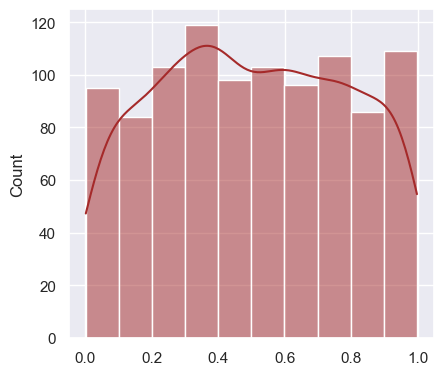

In [45]:
correctness = []
power = []

results = Parallel(n_jobs=-1)(delayed(cor_pow_cuped_rank)(i, shop, 1.01, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### Вывод: с помощью преобразований (Cuped, ранговое преобразование, логарифмирование) и их комбинаций можно повысить мощность теста

3. Реализовать разбивку на бакеты любым (правильным) способом, оценить t-критерием и сравнить с результатом без бакетирования:
- на логнормальном распределении (сгенерированные данные) (5 баллов)
- на метрике cart_added_cnt (5 баллов)

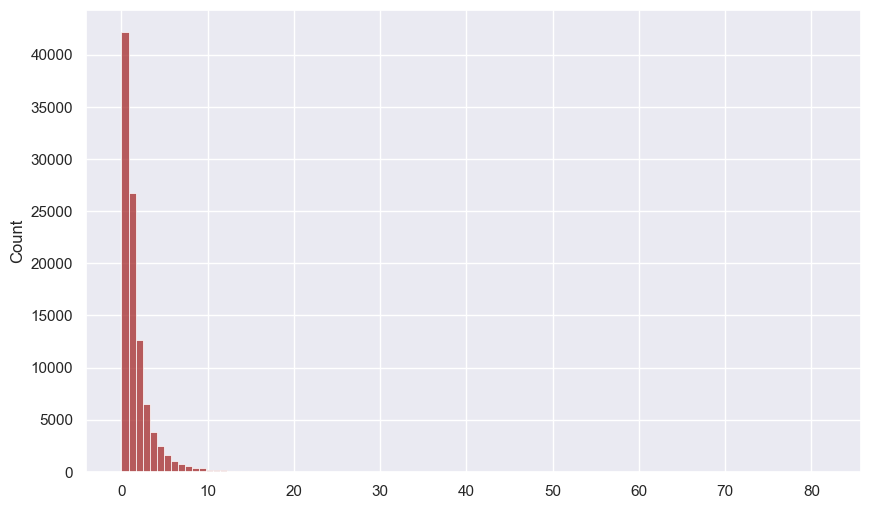

In [201]:
size = 100000
data = np.random.lognormal(0, 1, size)

sns.set(rc={'figure.figsize':(10, 6)})
sns.histplot(data, bins=100, kde=False, color='brown')
df = pd.DataFrame({"user_id": range(data.size), "metric": data})

In [202]:
def simple_test(i, shop, metric ,effect=1.05, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][metric]
    vec_b = new_df[(new_df['group'] == 'B')][metric]
    vec_b_effect = new_df[new_df['group'] == 'B'][metric] * effect
    # vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a, vec_b_effect).pvalue
    
    return p_cor, p_power












































































































































































































































































































































































































































































































































































































































































































































































100%|██████████| 1000/1000 [01:24<00:00, 11.83it/s]


 power: 95.5% , correctness: 95.7%


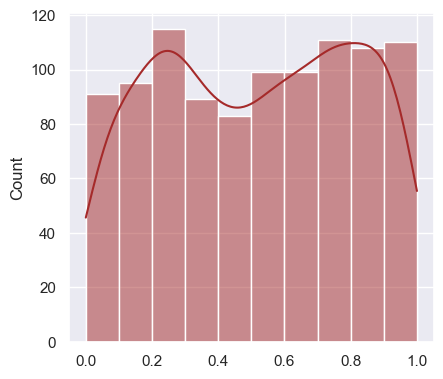

In [203]:
results = Parallel(n_jobs=-1)(delayed(simple_test)(i, df, 'metric' ,effect=1.03, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### Бакетирование

<Axes: xlabel='metric', ylabel='Count'>

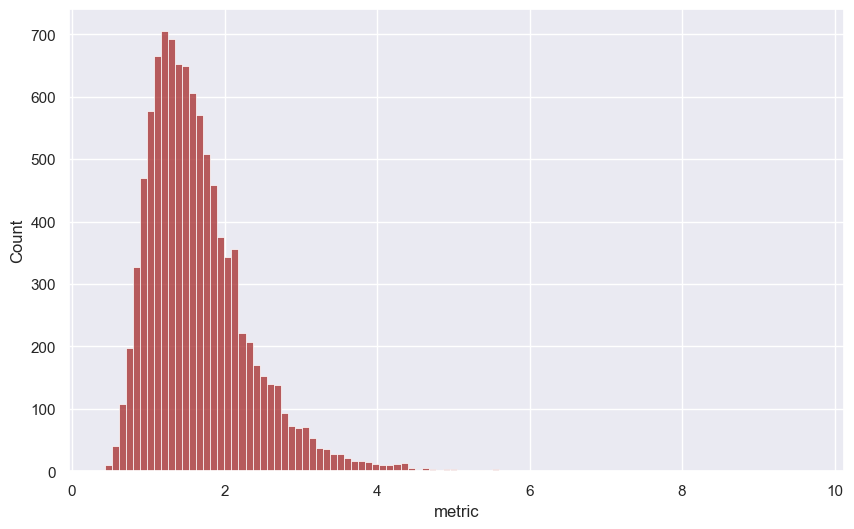

In [204]:
sample = 10


df_bucket = df['metric'].to_numpy().reshape(size // sample, -1).mean(axis=1)
df_bucket = pd.DataFrame({"user_id": range(size // sample), "metric": df_bucket})

sns.set(rc={'figure.figsize':(10, 6)})
sns.histplot(df_bucket['metric'], bins=100, kde=False, color='brown')


















































































































































































































































































































































































100%|██████████| 1000/1000 [00:07<00:00, 125.68it/s]


 power: 95.7% , correctness: 95.39999999999999%


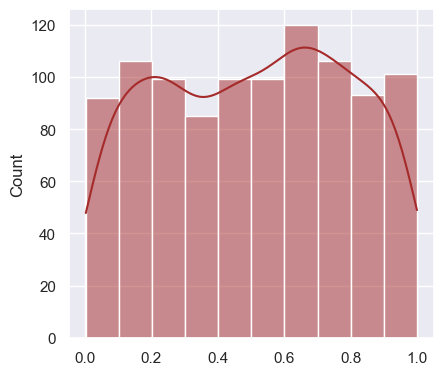

In [206]:
results = Parallel(n_jobs=-1)(delayed(simple_test)(i, df_bucket, 'metric' ,effect=1.03, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

### Примерно такие же результаты, но скорость значительно возрасла

- на метрике cart_added_cnt (5 баллов)

Без бакетирования

100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]


 power: 32.4% , correctness: 94.5%


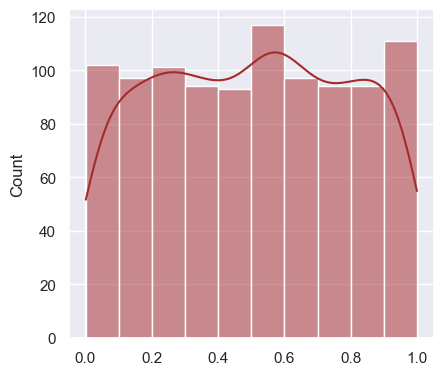

In [52]:
results = Parallel(n_jobs=-1)(delayed(simple_test)(i, shop, metric="cart_added_cnt", effect=1.03, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness = np.array([p[0] for p in results])
power = np.array([p[1] for p in results])

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Бакетирование

In [212]:
def get_bucket(df, metric, bucket_size):
    df_sorted = df
    bucket_size = len(df_sorted) // bucket_size
    df_sorted['bucket'] = pd.qcut(df_sorted.index, q=bucket_size, labels=False, duplicates='drop')
    df_bucketed = df_sorted.groupby('bucket', as_index=False)[metric].mean()
    df_bucketed = df_bucketed.rename(columns={"bucket": "user_id"})
    
    return df_bucketed

In [213]:
bucket_sizes = [10, 100, 1000, 10000]
correctness = [[] for _ in range(len(bucket_sizes))]
powers = [[] for _ in range(len(bucket_sizes))]

In [214]:
def process_iteration(shop):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')]['cart_added_cnt']
    vec_b = new_df[(new_df['group'] == 'B')]['cart_added_cnt']
    vec_b_effect = vec_b * 1.03

    p_cor = stats.ttest_ind(vec_a, vec_b).pvalue
    p_power = stats.ttest_ind(vec_a, vec_b_effect).pvalue

    return p_cor, p_power

In [215]:
def simple_test(i, shop, metric ,effect=1.05, criterion=stats.ttest_ind):
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    vec_a = new_df[(new_df['group'] == 'A')][metric]
    vec_b = new_df[(new_df['group'] == 'B')][metric]
    vec_b_effect = new_df[new_df['group'] == 'B'][metric] * effect
    # vec_b_effect = vec_b + stats.norm.rvs(loc=vec_b.mean() * 0.05, scale=0.35, size=len(vec_b))
    p_cor, p_power = criterion(vec_a, vec_b).pvalue, criterion(vec_a, vec_b_effect).pvalue
    
    return p_cor, p_power

In [216]:
for idx, bucket_size in enumerate(bucket_sizes):
    shop_bucket = get_bucket(shop.copy(), 'cart_added_cnt', bucket_size)

    # Parallelize the internal loop
    results = Parallel(n_jobs=-1)(delayed(process_iteration)(shop_bucket.copy()) for _ in range(1000))

    # Separate results
    correctness = np.array([result[0] for result in results])
    powers = np.array([result[1] for result in results])

    power_significance = (powers < 0.05).mean() * 100
    correctness_significance = (correctness < 0.05).mean() * 100

    print(f'Мощность при bucket_size = {bucket_size}: {power_significance:.2f}%')
    print(f'Корректность при bucket_size = {bucket_size}: {(1 - correctness_significance / 100) * 100:.2f}% \n')

Мощность при bucket_size = 10: 46.60%
Корректность при bucket_size = 10: 95.30% 

Мощность при bucket_size = 100: 48.30%
Корректность при bucket_size = 100: 94.50% 

Мощность при bucket_size = 1000: 26.90%
Корректность при bucket_size = 1000: 95.40% 

Мощность при bucket_size = 10000: 8.80%
Корректность при bucket_size = 10000: 95.30% 



Корректность не зависит от размера бакетов, а вот мощность уменьшается при увеличении размера бакета.

4. Реализовать постстратификацию на данных shop_metrics_old для метрики cart_added_cnt:
- на сочетании пола и возраста (возраст разбить на подгруппы: 18-24, 25-45, 46-60, 61-75, 76+) (5 баллов)
подсчитать результаты для случая без постстратификации и с постстратификацией. (дисперсию и среднее)
- проверить мощность и корректность t-критерия для постстратифицированного случая (5 баллов)


Без стратификации:

In [64]:
shop_old = shop_metrics_old.drop(columns=['group'])

In [175]:
mean_a = shop_old[shop_old['group'] == 'A']['cart_added_cnt'].mean()
mean_b = shop_old[shop_old['group'] == 'B']['cart_added_cnt'].mean()

std_a = shop_old[shop_old['group'] == 'A']['cart_added_cnt'].std()
std_b = shop_old[shop_old['group'] == 'B']['cart_added_cnt'].std()

n_a = len(shop_old[shop_old['group'] == 'A'])
n_b = len(shop_old[shop_old['group'] == 'B'])


In [176]:
print(f'Среднее для А и Б группы: {mean_a:.5f}, {mean_b:.5f}')
print(f'std для А и Б группы: {std_a:.5f}, {std_b:.5f}')

Среднее для А и Б группы: 0.12020, 0.12155
std для А и Б группы: 0.57669, 0.59876


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


 power: 87.3% , correctness: 94.89999999999999%


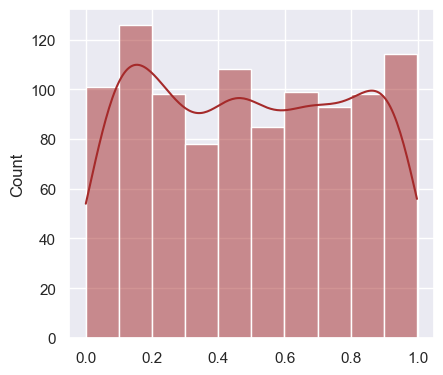

In [66]:
results = Parallel(n_jobs=-1)(delayed(simple_test)(i, shop_old, metric="cart_added_cnt", effect=1.05, criterion = stats.ttest_ind) for i in tqdm(range(1000)))

correctness = np.array([p[0] for p in results])
power = np.array([p[1] for p in results])

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Со стратификацией

In [81]:
shop_users_info["age_group"] = (
    shop_users_info["user_age"]
    .mask(shop_users_info.user_age <= 24, "18-24")
    .mask((shop_users_info.user_age >= 25) & (shop_users_info.user_age <= 45), "25-45")
    .mask((shop_users_info.user_age >= 46) & (shop_users_info.user_age <= 60), "46-60")
    .mask((shop_users_info.user_age >= 61) & (shop_users_info.user_age <= 75), "61-75")
    .mask(shop_users_info.user_age >= 76, "76+")
)

In [109]:
shop_old = pd.merge(shop_metrics_old[["user_id", "group", "cart_added_cnt"]], 
                    shop_users_info[["user_id", "age_group", "user_sex"]], on=["user_id"], how="left")

In [130]:
shop_old

,user_id,group,cart_added_cnt,age_group,user_sex,strats
0,1515915625353226922,B,0,46-60,f,f_46-60
1,1515915625353230067,A,0,46-60,m,m_46-60
2,1515915625353230683,A,0,18-24,f,f_18-24
3,1515915625353230922,A,0,25-45,m,m_25-45
4,1515915625353234047,A,0,25-45,f,f_25-45
...,...,...,...,...,...,...
406858,1515915625611023671,B,0,76+,m,m_76+
406859,1515915625611023730,B,0,25-45,m,m_25-45
406860,1515915625611024014,B,0,61-75,m,m_61-75
406861,1515915625611024020,B,0,46-60,f,f_46-60


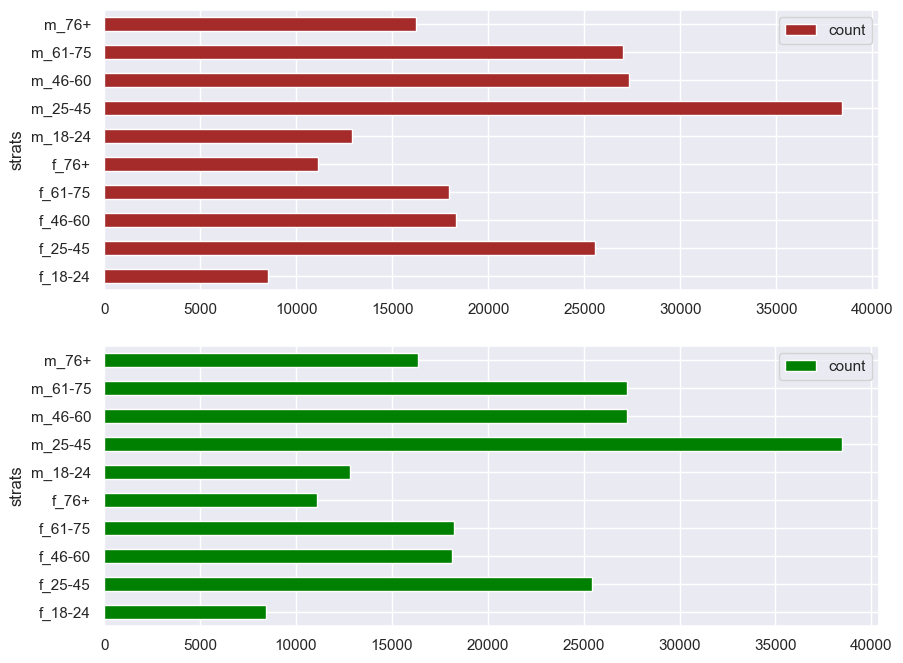

In [133]:
x = shop_old.groupby(["group", "strats"])[["user_id"]].count().rename(columns={"user_id": "count"})

f, axs = plt.subplots(nrows=2, figsize=(10,8))
x.loc["A"].plot.barh(color="brown", ax=axs[0])
x.loc["B"].plot.barh(color="green", ax=axs[1])
plt.grid(visible=True)

In [128]:
shop_old['strats'] = shop_old['user_sex'] + '_' + shop_old['age_group']

In [233]:
def get_mean_std_n(df):
    df['strats'] = df['user_sex'] + '_' + df['age_group']
    N = df['user_id'].nunique()
    strats_weights = df['strats'].value_counts() / N

    mean_a, mean_b = 0, 0
    var_a, var_b = 0, 0

    for strata in df['strats'].unique():
        mask_a = (df['group'] == 'A') & (df['strats'] == strata)
        mask_b = (df['group'] == 'B') & (df['strats'] == strata)
        
        mean_a += df[mask_a]['cart_added_cnt'].mean() * strats_weights[strata]
        mean_b += df[mask_b]['cart_added_cnt'].mean() * strats_weights[strata]
        var_a += df[mask_a]['cart_added_cnt'].var() * strats_weights[strata]
        var_b += df[mask_b]['cart_added_cnt'].var() * strats_weights[strata]

    std_a = (var_a**0.5)
    std_b = (var_b**0.5)

    n_a = len(df[df.group == 'A'])
    n_b = len(df[df.group == 'B'])

    return mean_a, mean_b, std_a, std_b, n_a, n_b

In [234]:
mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(shop_old)

t_stat, p_value = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b * 1.03, std_b, n_b)

print(f'Статистика t: {t_stat:.2f}')
print(f'P-значение: {p_value:.4f}')
print(f'Степени свободы: {n_a + n_b - 2}')

Статистика t: -2.71
P-значение: 0.0067
Степени свободы: 406861


Т-тест уловил статистическую значимость между группами

In [236]:
print(f'Среднее для А и Б группы: {mean_a:.5f}, {mean_b:.5f}')
print(f'std для А и Б группы: {std_a:.5f}, {std_b:.5f}')

Среднее для А и Б группы: 0.12021, 0.12156
std для А и Б группы: 0.57687, 0.59885


Видим, что средние и std поменялись после приминения стратификации, но лишь в 4-5 знаке после запятой.

In [237]:
def simple_test_last(i, shop, effect=1.05):
    shop = shop.drop(columns=['group'])
    new_group = groups_splitter(shop.copy(), user_salt=salt_generator())
    new_df = pd.merge(shop, new_group, how="left", on=['user_id']).drop_duplicates()

    mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(new_df)

    p_cor = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]

    new_df[(new_df['group'] == 'B')]['cart_added_cnt'] = new_df[(new_df['group'] == 'B')]['cart_added_cnt'] * effect
    mean_a, mean_b, std_a, std_b, n_a, n_b = get_mean_std_n(new_df)
    p_power = stats.ttest_ind_from_stats(mean_a, std_a, n_a, mean_b, std_b, n_b)[1]

    return p_cor, p_power









































































100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


 power: 5.0% , correctness: 95.0%


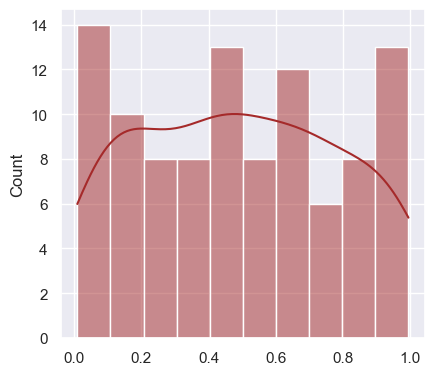

In [238]:
results = Parallel(n_jobs=-1)(delayed(simple_test_last)(i, shop_old, effect=1.05) for i in tqdm(range(100)))

correctness, power = zip(*results)

correctness = np.array(correctness)
sns.set(rc={'figure.figsize':(4.7,4.27)})
sns.histplot(data=correctness, bins=10, color='brown', kde=True)

power = np.array(power)

print(f' power: {(power[power < 0.05].shape[0] / power.shape[0]) * 100}% , correctness: {(1 - (correctness[correctness < 0.05].shape[0] / correctness.shape[0])) * 100}%')

Мощность в 5% совсем не радует. Возможно стоило не разбивать на так много групп, а стоило взять только группы по возрасту без учета пола.

In [199]:
scipy.stats.kstest(correctness, 'uniform')

KstestResult(statistic=0.111634150734928, pvalue=0.15324698518776014, statistic_location=0.691634150734928, statistic_sign=-1)